2023-11-13 15:59:24.555169: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 15:59:24.556293: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 15:59:24.580656: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 15:59:24.581116: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 15:59:25.001543: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10600     
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 25)            0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 10, 25)            5100      
                                                                 
 lstm_3 (LSTM)               (None, 10, 50)            15200     
                                                                 
 time_distributed (TimeDist  (None, 10, 2)             102       
 ributed)                                               

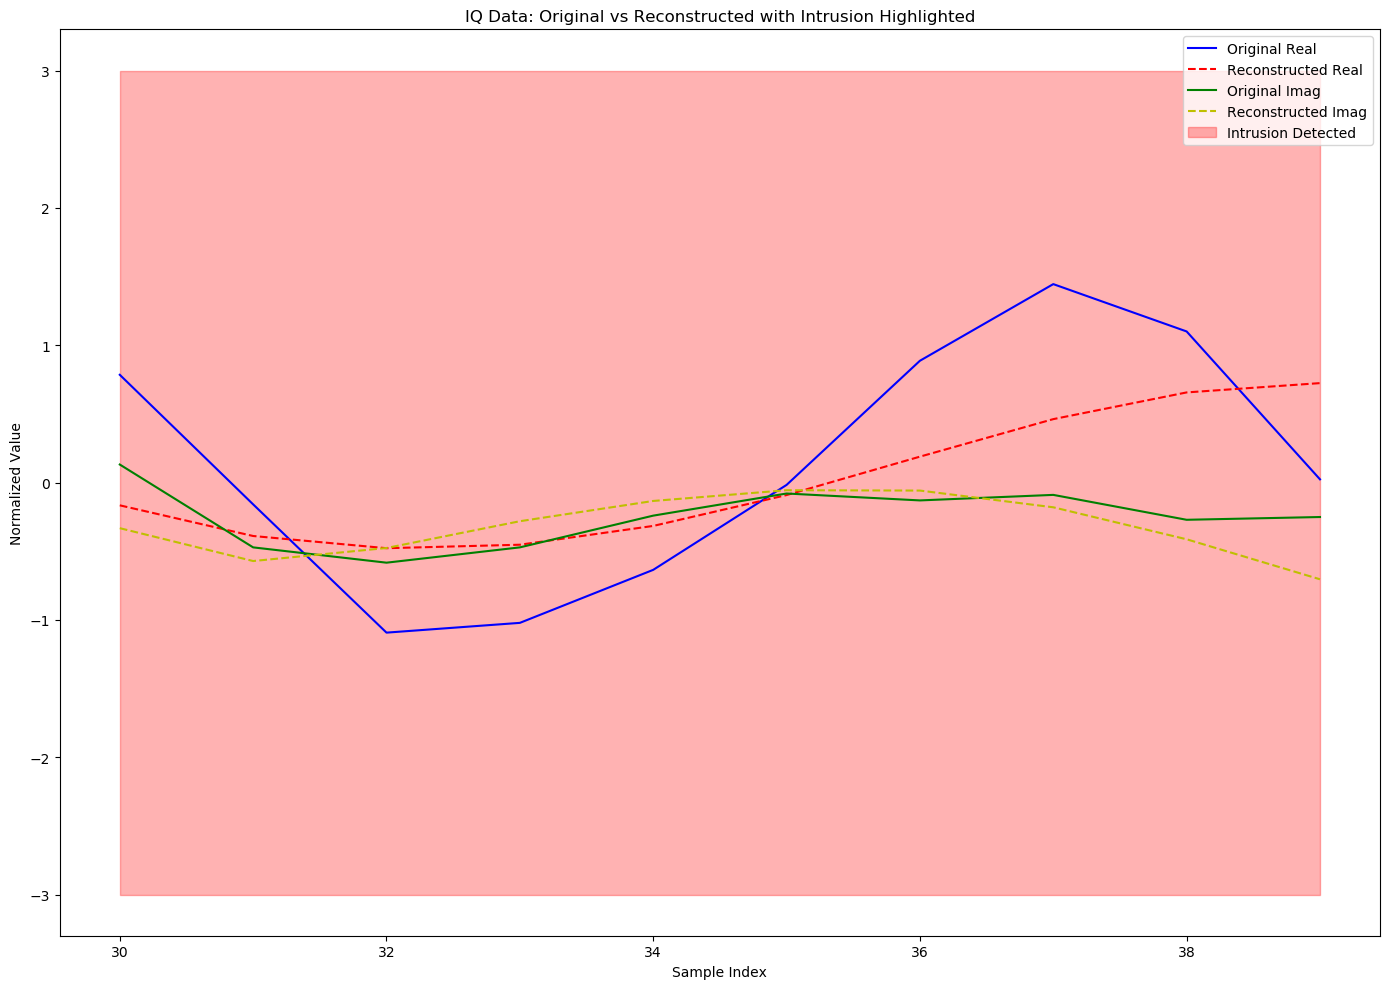

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt
import os
import struct

totalMagnitude = 0
totalnumberofsamples = 0
def load_data(filepath):
    _, file_extension = os.path.splitext(filepath)
    
    if file_extension == '.csv':
        df = pd.read_csv(filepath)
        samples = df['your_column_name'].values
    elif file_extension == '.dat':
        #Looks like DAT is binary encoded added a b in r as rb
        with open(filepath, 'rb') as f:
            samples = f.readlines()
        samples = np.array([sample.strip() for sample in samples])
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")
    
    return samples

def count_lines(filepath):
    with open(filepath, 'rb') as f:
        return sum(1 for _ in f)


class DataGenerator:        
    def __init__(self, filepath, batch_size, sequence_length, max_samples=None, for_training=True):
        self.filepath = filepath
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.max_samples = max_samples
        self.for_training = for_training
        self.samples = []
        self.binary_file = open(self.filepath, 'rb')  # Initialize the binary_file here
        self.reset()

    def reset(self):
        self.total_samples_processed = 0
        _, self.file_extension = os.path.splitext(self.filepath)


    def __iter__(self):
        self.binary_file.seek(0)  # reset file pointer
        self.samples = []
        return self
    
    def close(self):
        if not self.binary_file.closed:
            self.binary_file.close()

    def process_data(self, samples):
        real_parts = []
        imag_parts = []
        for sample in samples:
            #print('sample in process_data:', sample)
            try:
                cnum = complex(sample.replace('j', 'j'))
                real_parts.append(np.real(cnum))
                imag_parts.append(np.imag(cnum))
            except ValueError:
                continue

        #print('len(real_parts):', len(real_parts))
        #print('len(imag_parts):', len(imag_parts))
        real_parts = (real_parts - np.mean(real_parts)) / np.std(real_parts)
        imag_parts = (imag_parts - np.mean(imag_parts)) / np.std(imag_parts)

        X = [list(zip(real_parts[i:i+self.sequence_length], imag_parts[i:i+self.sequence_length])) for i in range(len(real_parts) - self.sequence_length)]
        #print('np.array(X):', np.array(X))
        #print('np.array(X).size:', np.array(X).size)
        return np.array(X)

    def __next__(self):
        chunksize = self.batch_size * self.sequence_length
        #print('chunksize = self.batch_size * self.sequence_length:', chunksize)
        global totalMagnitude  # Access the global variable
        global totalnumberofsamples  # Access the global variable
        
        if self.file_extension == '.dat':
            samples = []
            while True:
                binary_data = self.binary_file.read(8)
                if not binary_data:
                    break 
                decoded_data = struct.unpack('ff', binary_data)
                if decoded_data[0] == 0 and decoded_data[1] == 0:
                    decoded_line = f"0j\n"
                    #Calculates the mangitude of the complex number
                    totalMagnitude += abs(complex(decoded_line)) 
                    totalnumberofsamples +=1
                else:
                    if decoded_data[1] >= 0:
                        decoded_line = f"{decoded_data[0]}+{decoded_data[1]}j\n"
                        #Calculates the mangitude of the complex number
                        totalMagnitude += abs(complex(decoded_line)) 
                        totalnumberofsamples +=1                        
                    else:
                        decoded_line = f"{decoded_data[0]}{decoded_data[1]}j\n"
                        #Calculates the mangitude of the complex number
                        totalMagnitude += abs(complex(decoded_line)) 
                        totalnumberofsamples +=1                       
                samples.append(decoded_line)

                if self.max_samples and self.total_samples_processed >= self.max_samples:
                    raise StopIteration
                self.total_samples_processed += 1
                #print('len(samples):', len(samples))
                if len(samples) == chunksize:
                    X_chunk = self.process_data(samples)
                    #print('X_chunk size at the end of next:', X_chunk.size)
                    if self.for_training:
                        return X_chunk, X_chunk
                    else:
                        return X_chunk
                    samples = []

        
        else:
            raise StopIteration
def plot_with_intrusions4(X_chunk_test, X_chunk_pred, jamming_detected, sequence_length):
    intrusion_indices = np.where(jamming_detected)[0]  

    if len(intrusion_indices) == 0:
        print("No intrusions detected for plotting.")
        return  # Exit the function if no intrusions detected

    plt.figure(figsize=(14, 10))
    legend_added = False  # Control variable for legend

    for idx, intrusion in enumerate(jamming_detected):
        if intrusion:  # Check if intrusion is detected for the sequence
            start_idx = idx * sequence_length
            end_idx = start_idx + sequence_length
            time_steps = np.arange(start_idx, end_idx)

            # Plot original and reconstructed data for the real and imaginary parts
            plt.plot(time_steps, X_chunk_test[idx, :, 0], 'b-', label='Original Real' if not legend_added else "")
            plt.plot(time_steps, X_chunk_pred[idx, :, 0], 'r--', label='Reconstructed Real' if not legend_added else "")
            plt.plot(time_steps, X_chunk_test[idx, :, 1], 'g-', label='Original Imag' if not legend_added else "")
            plt.plot(time_steps, X_chunk_pred[idx, :, 1], 'y--', label='Reconstructed Imag' if not legend_added else "")
            
            # Highlight the area of intrusion
            plt.fill_between(time_steps, -3, 3, where=intrusion, color='red', alpha=0.3, label='Intrusion Detected' if not legend_added else "")
            legend_added = True  # Set the flag to True after adding legend

    # Add legend
    if legend_added:
        plt.legend()
    plt.title('IQ Data: Original vs Reconstructed with Intrusion Highlighted')
    plt.xlabel('Sample Index')
    plt.ylabel('Normalized Value')
    plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
    plt.show()
sequence_length = 10

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 2), return_sequences=True))
model.add(LSTM(25, activation='relu', return_sequences=False))
model.add(RepeatVector(sequence_length))
model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(2)))

model.summary()
model.compile(optimizer='adam', loss='mse')

# first I need to train pure data batch by batch
batch_size = 20
num_pure_samples = count_lines('/home/mreza/5G accelerator/models/5G_DL_IQ_no_jamming_0924.dat')
#print('num_pure_samples:', num_pure_samples)

max_train_samples = 100000  # I limit the train or can put None for whole data
train_steps = (min(num_pure_samples, max_train_samples) if 
               max_train_samples else num_pure_samples) // (batch_size * sequence_length)


train_gen_instance = DataGenerator('/home/mreza/5G accelerator/models/5G_DL_IQ_no_jamming_0924.dat', 
                                   batch_size=batch_size, sequence_length=sequence_length, 
                                   max_samples=max_train_samples, for_training=True)

# Modify training loop
num_epochs = 2  # You can adjust the number of epochs as needed
steps_per_epoch = train_steps  # Assuming one epoch processes all the data
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_gen_instance.reset()  # Reset the generator at the beginning of each epoch
    for step in range(steps_per_epoch):
        try:
            X_chunk, Y_chunk = next(train_gen_instance)
        except StopIteration:
            train_gen_instance.reset()  # Reset the generator when it runs out of data
            X_chunk, Y_chunk = next(train_gen_instance)

        model.train_on_batch(X_chunk, Y_chunk)
        print(f"Step {step + 1}/{steps_per_epoch}", end='\r')
    print()
combined_gen_instance = DataGenerator('/home/mreza/5G accelerator/models/5G_DL_IQ_with_periodic_jamming_0928_02.dat', 
                                      batch_size=batch_size, sequence_length=sequence_length, 
                                      for_training=False)


num_samples = count_lines('/home/mreza/5G accelerator/models/5G_DL_IQ_no_jamming_0924.dat')
print('num_samples = count_lines:', num_samples)
max_predictions = num_samples // (batch_size * sequence_length)

#3500
num_predictions = 2  # or any other large number
num_predictions = min(num_predictions, max_predictions)

print(f"Maximum number of predictions available: {max_predictions}")
print(f"Number of predictions to be performed: {num_predictions}")

reconstruction_errors = []
try:
    for _ in range(num_predictions):
        print('prediction number:', _)
        X_chunk_test = next(combined_gen_instance)
        print('X_chunk_test.size:', X_chunk_test.size)
        print('X_chunk_test.shape:', X_chunk_test.shape)
        X_chunk_pred = model.predict(X_chunk_test)
        print('X_chunk_pred .size:', X_chunk_pred.size)
        print('X_chunk_pred .shape:', X_chunk_pred.shape)
        chunk_errors = np.mean(np.square(X_chunk_test - X_chunk_pred), axis=1)
        print('chunk_errors.size', chunk_errors.size)
        reconstruction_errors.extend(chunk_errors)
except StopIteration:
    print("All samples processed.")
        
# reconstruction_error = np.array(reconstruction_errors)
#---------------------------------------111-----------------------------------
reconstruction_error = np.array(reconstruction_errors)  # It's already flat, size (num_predictions * batch_size * sequence_length * 2)

# Calculate the max error for each sequence across all time steps, considering real and imaginary parts separately
max_error_per_sequence = reconstruction_error.reshape(-1, 2).max(axis=1)  # Shape (num_predictions * batch_size * sequence_length,)

# Now, get the error per sequence (not per step) by taking the mean of max errors in chunks of sequence_length
error_per_sequence = max_error_per_sequence.reshape(-1, sequence_length).mean(axis=1)  # Shape (num_predictions * batch_size,)

# Determine the threshold for intrusion
threshold = np.percentile(error_per_sequence, 95)

# Detect sequences where the error exceeds the threshold
is_intrusion_detected = error_per_sequence > threshold  # Boolean array for sequences, shape (num_predictions * batch_size,)
num_total_sequences = num_predictions * batch_size -2
print('len(is_intrusion_detected):', len(is_intrusion_detected))
print('num_total_sequences:', num_total_sequences)

# Since we're interested in plotting only the last batch, we take the last 'batch_size' detected intrusions
if len(is_intrusion_detected) == num_total_sequences:
    print("Correct number of sequences for intrusion detection.")
    last_batch_intrusions = is_intrusion_detected[-batch_size:]  # Get the last batch_size elements
    plot_with_intrusions4(X_chunk_test, X_chunk_pred, last_batch_intrusions, sequence_length)
else:
    print("Incorrect number of sequences for intrusion detection.")

#---------------------------------------222-----------------------------------


# # # set threshold
# threshold = np.percentile(reconstruction_error, 95)
# # #threshold =totalMagnitude /totalnumberofsamples
# # print("Total number of samples", totalnumberofsamples)
# # print('threshold magnitude:', threshold)
# # print('threshold percentile:', np.percentile(reconstruction_error, 95))

# jamming_detected = reconstruction_error > threshold
# # print('jamming_detected:', jamming_detected)
# # print("Reconstruction error.shape:", reconstruction_error.shape)
# # print('jamming_detected.shape:', jamming_detected.shape)
# train_gen_instance.close()
# combined_gen_instance.close()
# #Table to get insight
# flattened_jamming_detected = jamming_detected.flatten()
# real_part_detected = jamming_detected[:, 0]
# imag_part_detected = jamming_detected[:, 1]
# real_true_count = np.sum(real_part_detected)
# real_false_count = len(real_part_detected) - real_true_count
# imag_true_count = np.sum(imag_part_detected)
# imag_false_count = len(imag_part_detected) - imag_true_count
# overall_true_count = np.sum(flattened_jamming_detected)
# overall_false_count = len(flattened_jamming_detected) - overall_true_count
# df = pd.DataFrame({
#     'Part': ['Real', 'Imaginary', 'Overall'],
#     'True Count': [real_true_count, imag_true_count, overall_true_count],
#     'False Count': [real_false_count, imag_false_count, overall_false_count]
# })

# print(df)
# num_jamming_detected = np.sum(jamming_detected)
# print(f"Number of jamming sequences detected: {num_jamming_detected} out of {len(flattened_jamming_detected)} sequences")

# # Define the number of sequences to plot together
# n = 9  # You can change this to the desired number of sequences
# sample_length = sequence_length * n
# # Select a random sample for plotting
# sample_index = np.random.choice(len(X_chunk_test) - sample_length + 1)
# # Extract the original and reconstructed samples
# original_sample = X_chunk_test[sample_index:sample_index + sample_length]
# reconstructed_sample = X_chunk_pred[sample_index:sample_index + sample_length]
# # After generating X_chunk_test and X_chunk_pred
# print("Shape of X_chunk_test:", X_chunk_test.shape)
# print("Shape of X_chunk_pred:", X_chunk_pred.shape)
# # Check if X_chunk_test is a 2D array with the second dimension being sequence_length * 2 (for real and imag parts)
# if X_chunk_test.ndim == 3 and X_chunk_test.shape[1] == sequence_length and X_chunk_test.shape[2] == 2:
#     print("X_chunk_test is in the correct shape.")
# else:
#     print("X_chunk_test is NOT in the correct shape. Expected shape: (num_sequences, sequence_length, 2)")

# # Check if X_chunk_pred has the same shape as X_chunk_test
# if X_chunk_pred.shape == X_chunk_test.shape:
#     print("X_chunk_pred is in the correct shape.")
# else:
#     print("X_chunk_pred is NOT in the correct shape. Expected shape:", X_chunk_test.shape)

# # Before plotting, check if the length of jamming_detected is equal to the number of sequences
# num_sequences = X_chunk_test.shape[0]  # Number of sequences should be the first dimension of X_chunk_test
# if len(jamming_detected) == num_sequences:
#     print("jamming_detected array length matches the number of sequences.")
# else:
#     print("Mismatch! jamming_detected array length:", len(jamming_detected), "Number of sequences:", num_sequences)

# jamming_detected_pairs = reconstruction_error.reshape(-1, 2)  # Reshape to have 190 rows and 2 columns

# # Create a boolean array with 'True' if either real or imaginary part error exceeds the threshold
# jamming_detected_per_sequence = np.any(jamming_detected_pairs > threshold, axis=1)

# # Verify the shapes to debug
# print("jamming_detected_pairs.shape:", jamming_detected_pairs.shape)
# print("jamming_detected_per_sequence.shape:", jamming_detected_per_sequence.shape)
# print("X_chunk_test.shape[0]:", X_chunk_test.shape[0])

# # There should be no need for an assertion error if the shapes match
# if jamming_detected_per_sequence.size == X_chunk_test.shape[0]:
#     # Call the plotting function with the correctly shaped data
#     plot_with_intrusions4(X_chunk_test, X_chunk_pred, jamming_detected_per_sequence, sequence_length)
# else:
#     print("The length of the detected jamming sequences does not match the number of test sequences.")
